In [1]:
# Source dataset
# https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise

In [2]:
# Load libraries
import keras
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


In [3]:
# Read the input data
df = pd.read_csv('airfoil_self_noise.txt', sep='\t', header=None,
                 names=['frequency','angle_of_attack','chord_length',
                          'free_stream_velocity','suction_side_thickness',
                          'scaled_sound_level_dbs'])
df.shape

(1503, 6)

In [4]:
# Describe a few records
df.head()

,frequency,angle_of_attack,chord_length,free_stream_velocity,suction_side_thickness,scaled_sound_level_dbs
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [5]:
# Split the data into train and test set
X = np.asarray(df.drop(['scaled_sound_level_dbs'], 1))
y = np.asarray(df['scaled_sound_level_dbs'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1127, 5) (376, 5) (1127,) (376,)


In [6]:
# Normalize the data
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test -= mean
X_test /= std

In [7]:
# Initial base model

from keras import models
from keras import layers

num_epochs = 100
all_mae_histories = []

def build_model():
    
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

model = build_model()
base_model_start_time = datetime.datetime.now()
base_model_history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=1, verbose=0)
base_model_end_time = datetime.datetime.now()
base_model_run_time = base_model_end_time - base_model_start_time
print("Base model run time: ", base_model_run_time)
test_mse, test_mae = model.evaluate(X_test, y_test, verbose=0)

Base model run time:  0:02:12.330219


In [8]:
test_mse, test_mae

(7.730957274741315, 2.0374300074070057)

In [11]:
# Base model conclusion
# The model has a mean absolute error of 2.03 decibels with the target values

In [9]:
# K fold validation model

k = 4
num_val_samples = len(X) // k
num_epochs = 100
all_mae_histories = []

start_time = datetime.datetime.now()

for i in range(k):
    print('processing fold #', i)
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],X[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples:],y[(i + 1) * num_val_samples:]],axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
end_time = datetime.datetime.now()
print("4 fold validations run time: ", end_time - start_time)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
4 fold validations run time:  0:10:36.603662


In [10]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

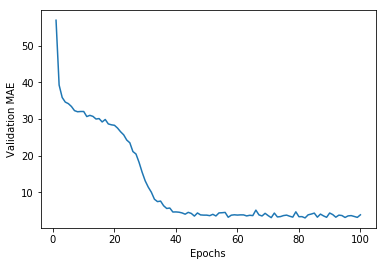

In [11]:
# Plot MAE on validation data
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

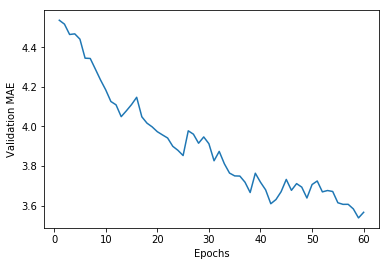

In [15]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[40:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [16]:
# New model for testing the test dataset
model = build_model()
model.fit(X_train, y_train, epochs=40, batch_size=1, verbose=0)
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

376/376 [==============================] - 0s 330us/step


In [17]:
test_mae_score

2.545525799406336

In [18]:
# Conclusion
# Here K fold validation model "mae" can be made in par with base model with additional fine tuning of hyperparameters  